In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import scipy.integrate as integrate

import torch
import torchquad
from numba import cuda


In [2]:
# TODO sort this device mess out

device = cuda.get_current_device()
device.reset()
torch.set_num_threads(2)
device = "cpu"#torch.device( "cuda" if torch.cuda.is_available() else "cpu")
print( "Using device: " + str( device ), flush=True)

Using device: cpu


In [3]:
# may want to revisit these choices
integrator = torchquad.Trapezoid()
N_integrator = 500


In [4]:
# ansatz helper functions

# g_coeffs: M x N matrix such that g = sum_{m, n} g_mn t^n alpha ^m
    # 1st row is g* term

def f(t, alpha, g_coeffs, mstar):
    M,N = g_coeffs.shape
    g_star = alpha**mstar * torch.abs(sum([g_coeffs[0,n]*torch.pow(t,n).to(device)/torch.tensor(np.math.factorial(n), device=device) for n in range(N) ]))
    g_higher = sum([alpha**(mstar + m) * g_coeffs[m,n]*torch.pow(t,n).to(device)/torch.tensor((np.math.factorial(n)*np.math.factorial(m)), device=device) for n in range(N) for m in range(1,M) ])
    return g_star*torch.exp(-g_higher)


def q(t, alpha, g_coeffs, mstar):

    f_of_t = lambda tt: f(tt, alpha, g_coeffs, mstar)
    
    intfunc = lambda tt: integrator.integrate(f_of_t, dim=1, N=N_integrator, integration_domain=[[0, tt]])

    # vmap does not like the torch integrator but it's running decently quickly now...
    #vec_int = torch.func.vmap(intfunc)
    #exp_term = vec_int(t)

    exp_term = torch.tensor([intfunc(tt) for tt in t])

    return f_of_t(t)*torch.exp(-exp_term).to(device)

/global/homes/r/rmastand/.local/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/global/homes/r/rmastand/.local/lib/python3.8/site-packages/torchquad/integration/utils.py:248: UserWarning: DEPRECATION WARNING: In future versions of torchquad, an array-like object will be returned.
  warnings.warn(


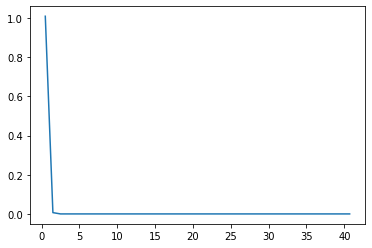

In [5]:

g_coeffs = torch.tensor(np.array([[-1, -2, 0], [-4,-2,-1], [-5,1,2]]))
#print(g_coeffs)
t = torch.linspace(0.5, 100, 100)


plt.figure()
plt.plot(t, q(t, 0.1, g_coeffs, 0).detach().cpu().numpy())
plt.show()

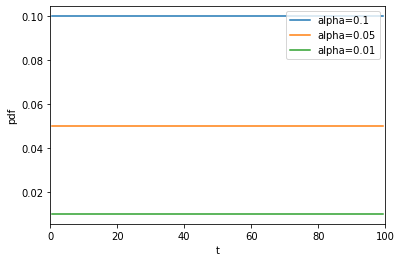

In [6]:
# choose data distribution

xlim = 100
nbins = 80

t_bins = torch.linspace(0, xlim, nbins)
t_bin_centers = 0.5*(t_bins[1:] + t_bins[:-1]) 


def get_pdf(alpha):
    
    y = torch.full(t_bin_centers.shape, alpha, device=device)
    #y += torch.normal(mean=0,std=0.0001, size=t_bin_centers.shape)
  
    return y


plt.figure()
for alpha in [0.1, 0.05, 0.01]:
    plt.plot(t_bin_centers,  get_pdf(alpha).detach().cpu().numpy(), label = f"alpha={alpha}")
plt.legend()
plt.xlim(0, xlim)
plt.xlabel("t")
plt.ylabel("pdf")
plt.show()

In [7]:
# Initialize the g_coefficients

mstar = 1
g_coeffs_to_fit = 0.1*torch.rand(size=(3,2)).float()
#g_coeffs_to_fit = torch.tensor(np.array([[1, 0, 0], [0,0, 0],[0,0, 0]]), device=device).float()

print(g_coeffs_to_fit)

tensor([[0.0216, 0.0503],
        [0.0683, 0.0800],
        [0.0364, 0.0576]])


In [8]:
from torch.autograd.functional import jacobian


epochs = 500
batch_size = 100
lr = 0.01


helper_ansatz = lambda a: q(t_bin_centers, a, g_coeffs_to_fit, mstar)
            
# TODO: results may be sensitive to the binning choice...


#t_bins = torch.logspace(-3, 2, nbins)
#t_bin_centers = np.sqrt((t_bins[1:] * t_bins[:-1]))

def train(epochs, lr = 1e-3):


    g_coeffs_to_fit.requires_grad_()
    optimizer = torch.optim.AdamW([g_coeffs_to_fit], lr=lr)

    MSE_criterion = torch.nn.MSELoss()

    losses = np.zeros(shape = (epochs, 1))
    g_coeffs_log = np.zeros(shape = (epochs+1, g_coeffs_to_fit.shape[0],  g_coeffs_to_fit.shape[1]))

    g_coeffs_log[0] = g_coeffs_to_fit.detach().cpu().numpy()
    
    for epoch in tqdm(range(epochs)):

        batch_data_pdf = torch.zeros(size=(batch_size*(nbins-1),))
        batch_ansatz = torch.zeros(size=(batch_size*(nbins-1),))


        optimizer.zero_grad()

        for bs in range(batch_size):
    
            # generate a random alpha for the epoch
            loc_alpha = torch.distributions.Exponential(1 / 0.118).sample().to(device)
            # alpha = torch.rand(batch_conditional)
    
            # generate training data
            loc_data_pdf = get_pdf(loc_alpha)

            # calculate taylor components of the ansatz
            
            # q(0)
            # TODO if mstar > m, then we only need to start at the d^m derivative since all lower ones will be zero
            loc_ansatz_0 = helper_ansatz(0)
    
            # dq / d alpha
            loc_ansatz_1 = torch.autograd.functional.jacobian(helper_ansatz, torch.tensor([0.0]), create_graph=True, vectorize=False).reshape(-1,).to(device)
            # TODO higher derivatives
    
            loc_ansatz = loc_ansatz_0 + loc_alpha*loc_ansatz_1

            # TODO: rescale by alpha? should all items in the batch have the same weight?
            batch_data_pdf[bs*(nbins-1):(bs+1)*(nbins-1)] = loc_data_pdf
            batch_ansatz[bs*(nbins-1):(bs+1)*(nbins-1)] = loc_ansatz

    
            """
            plt.figure()
            plt.plot(t_bin_centers.detach().cpu().numpy(), loc_data_pdf)
            plt.plot(t_bin_centers.detach().cpu().numpy(), loc_ansatz.detach().cpu().numpy())
            plt.title(loc_alpha)
            plt.show()
            """

        loss = MSE_criterion(batch_data_pdf.float(), batch_ansatz.float())
           
        loss.backward()
        optimizer.step()

        # log 
        losses[epoch] = loss.detach().cpu().numpy()
        g_coeffs_log[epoch+1] = g_coeffs_to_fit.detach().cpu().numpy()


    return losses, g_coeffs_log

losses, g_coeffs_log = train(epochs, lr =lr)


100%|██████████| 500/500 [2:33:03<00:00, 18.37s/it]  


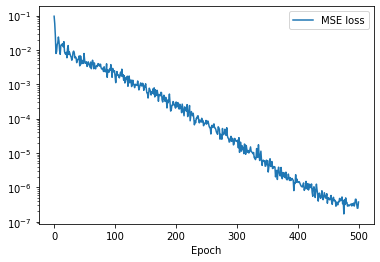

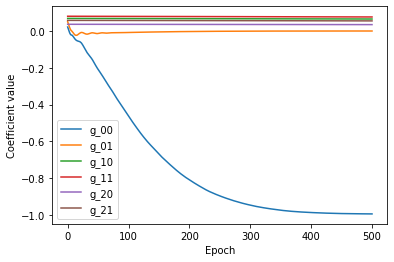

In [9]:
plt.figure()

plt.plot(losses, label = "MSE loss")
plt.legend()
plt.yscale("log")

plt.xlabel("Epoch")
plt.show()

plt.figure()
for m in range(g_coeffs_log.shape[1]):
    for n in range(g_coeffs_log.shape[2]):

        plt.plot(g_coeffs_log[:,m,n], label = f"g_{m}{n}")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Coefficient value")
plt.show()

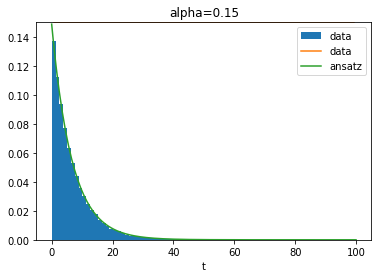

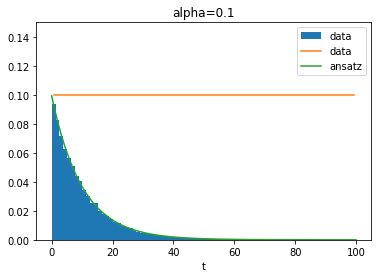

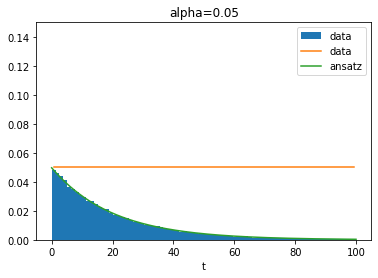

In [10]:


for alpha in [0.15, 0.1, 0.05]:
    
     
    # generate training data
    #loc_data = get_data(N_data, alpha)
    # histogram
    #loc_data_pdf, _ = np.histogram(loc_data, bins = t_bins, density = True)
    
    
    
    tt = torch.linspace(0, xlim, 200)
    loc_ansatz = q(tt , alpha, g_coeffs_to_fit, mstar)
    
    plt.figure()
    plt.hist(np.random.exponential(size=50000, scale = (1.0/alpha)), bins = t_bins, density = True, label = "data")
    plt.plot(t_bin_centers.detach().cpu().numpy(), get_pdf(alpha), label = "data")
    plt.plot(tt , loc_ansatz.detach().cpu().numpy(), label = "ansatz")
    plt.legend()
    plt.xlabel("t")
    plt.title(f"alpha={alpha}")
    plt.ylim(0, 0.15)
    plt.show()

In [11]:
print(g_coeffs_to_fit)

tensor([[-9.9341e-01, -9.8879e-05],
        [ 6.4974e-02,  7.6137e-02],
        [ 3.4578e-02,  5.4797e-02]], requires_grad=True)
